Import neccessary libraries:


In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sb
import sklearn 

Reading training and testing data and saving to csv files:

In [2]:
df_train = pd.read_csv("../input/train.csv", nrows = 100000, parse_dates = ["pickup_datetime"])
df_test = pd.read_csv("../input/test.csv", parse_dates = ["pickup_datetime"])


Exploring data:

In [3]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


**Question 1:**

Looking at the description of the training dataset, we find many anomalities data points. They include: 

1. Some fare amounts are negative and some are too high (up to 150-200usd), which we think might be wrongly input data. We will omit these samples. About the minimum fare values, we will have it to be 2.5usd (instead of 0usd), since this is the base amount of the fare.
2. Some values of longtitude and latitude are too large or too small, according to google map, not point to New York at all. We will omit these samples by defining a bounding box for NYC. However, rather than cropping the bounding box from the map, we would use the max and min values of the coordinates from the testing dataset. This way, we make sure to cover all possibles values in the testing dataset. 
3. We also check if there is any null value. Turns out to be very many. We will omit these samples.

Then we show the numbers of samples before and after preprocessing.


In [7]:
print('Previous number of training samples:', len(df_train))
df_train = df_train[(df_train.fare_amount>=2.5) & (df_train.fare_amount<150)]
df_train = df_train.dropna(how = 'any', axis = 'rows')
bounding_box = [40.488605, 40.88557, -73.673054, -74.279102]
def in_bounding_box(la_1,la_2,lon_1,lon_2,df):
    return (((np.abs(df.pickup_longitude - lon_1) + np.abs(df.pickup_longitude - lon_2)) == np.abs(lon_1 - lon_2)) 
        & ((np.abs(df.pickup_latitude - la_1) + np.abs(df.pickup_latitude - la_2)) == np.abs(la_1 - la_2))
        & ((np.abs(df.dropoff_longitude - lon_1) + np.abs(df.dropoff_longitude - lon_2)) == np.abs(lon_1 - lon_2)) 
        & ((np.abs(df.dropoff_latitude - la_1) + np.abs(df.dropoff_latitude - la_2)) == np.abs(la_1 - la_2)))   
df_train = df_train[in_bounding_box(bounding_box[0],bounding_box[1],bounding_box[2],bounding_box[3],df_train)]  
print('Post-preprocessing number of training samples:', len(df_train))

Previous number of training samples: 97653
Post-preprocessing number of training samples: 97648


**Question 2:**

We will compute the Pearson correlation between the following:
* Euclidean distance of the ride and the taxi fare
* Time of day and distance traveled
* Time of day and the taxi fare

For the Euclidean distance, we build a function to calculate based on the Haversin formula provided in the page: https://en.wikipedia.org/wiki/Haversine_formula.





In [8]:
def surface_distance(lat1, lon1, lat2, lon2):
    p = np.pi/180
    c = (0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2)
    distance = 7917.5 * np.arcsin(np.sqrt(c))
    return  distance
df_train['distance'] = surface_distance(df_train['pickup_latitude'],df_train['pickup_longitude'],df_train['dropoff_latitude'],df_train['dropoff_longitude'])
corr1 = df_train['distance'].corr(df_train['fare_amount'])
corr2 = df_train['fare_amount'].corr(df_train['pickup_datetime'].dt.hour)
corr3 =  df_train['distance'].corr(df_train['pickup_datetime'].dt.hour)
print(corr1)
print(corr2)
print(corr3)

0.8669170453030367
-0.018025496358505123
-0.03140706671656727


We see that the highest correlation is between the distance and the fare amount, which seems obvious. The second and third correlations are not high at all. Maybe because they don't have a strong linear relationship with the fare amount and ride distances. However, they still may have a relationship in another form. We will later plot the figures between these features against fare amount to have a better view.

**Question 3:**

Now we plot the scatter figure of each pair of features to visualize the correlation values. 

Here, for the time of the day feature, we will make it finer (to minutes) by interpolating the middle points. 

Text(0,0.5,'Distance')

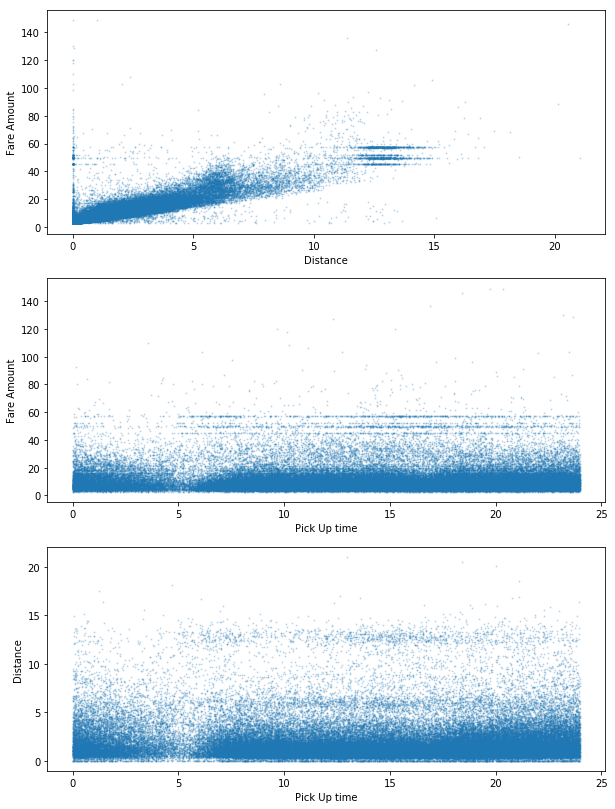

In [9]:
fig, plots = plt.pyplot.subplots(3,1,figsize=(10,14))
df_train['time_of_day'] = df_train['pickup_datetime'].dt.hour
plots[0].scatter(df_train['distance'],df_train['fare_amount'],alpha=0.2, s=1)
plots[0].set_xlabel('Distance')
plots[0].set_ylabel('Fare Amount')
plots[1].scatter(df_train['time_of_day'] + df_train['pickup_datetime'].dt.minute/60,df_train['fare_amount'],alpha=0.2,s=1)
plots[1].set_xlabel('Pick Up time')
plots[1].set_ylabel('Fare Amount')
plots[2].scatter(df_train['time_of_day'] + df_train['pickup_datetime'].dt.minute/60,df_train['distance'],alpha=0.2, s=1)
plots[2].set_xlabel('Pick Up time')
plots[2].set_ylabel('Distance')

Apparently, we find quite a linear relationship between the distance and fare amount feature. For the other two correlations, although that we don't see a linear relationship, but we still find a relationship between the two variables. Indeed, the plots show that the time of day does affect the distance as well as the fare amount. To be particular, in the time between 12am - 7am, there is a decrease in both distance and fare amount. This can be explained intuitively by the fact that people are sleeping at the time. Therefore, we should take the feature of time of day into consideration when predicting fare amount. Besides, we also find out that, the fare price in the morning and at night are different, according to this site https://www1.nyc.gov/nyc-resources/service/1271/yellow-taxi-fares.

On the other hand, we find something very interesting in the three plots. That there are many completely aligned straight stroke of points on the plots.  This might be because of one common ride that many people take. Based on three plots, we guess that this ride usually costs about 50$, and about 15 miles long.

We try to find out what are these "hot-splot" by filtering out these data points and investigate to see where the ride go from/to. It turns out that all of these pick-up/drop-off points cluster at the JFK airport, which is quite far from the downtown. Checking on the internet, we find that there is a "fixed" fare amount to go from/to JFK to/from Manhattan, which is about 51$. So this likely to be the reason for those abnormal straight clusters in the scatter plot.



**Question 4 and 5:**
    
Now we will play around, trying stuffs to see if there are any interesting insights from the training dataset.

* *Visualization*

First, to easily visualize all the points, we will plot all of them on a map of NYC. Using the map image here: 'https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png'. This idea comes from Albert van Breemen, a user on Kaggle that also takes participate in the competition. The function code is written partly based on his implementation.    

Caveat: The code below is commented because in Kernel Kaggle, for some reason the site cannot be reached (on my computer it still works fine). So I include a link below to the image after plotting to illustrate my point.

In [11]:
# nyc_map_zoom = plt.pyplot.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')
# BB_zoom = [ -74.3, -73.7, 40.5, 40.9]
# fig, axs = plt.pyplot.subplots(2, 1, figsize=(20,20))
# axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, s=10, alpha=0.2, c='r')
# axs[0].set_title('Pickup spots')
# axs[0].set_ylim((bounding_box[2], bounding_box[3]))
# axs[0].set_xlim((bounding_box[0], bounding_box[1]))
# axs[0].imshow(nyc_map_zoom, zorder=0, extent=BB)
#
# axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude,zorder=1, s=10, alpha=0.2, c='r')
# axs[1].set_title('Dropoff spots')
# axs[1].set_ylim((bounding_box[2], bounding_box[3]))
# axs[1].set_xlim((bounding_box[0], bounding_box[1]))
# axs[1].imshow(nyc_map_zoom, zorder=0, extent=bounding_box)

Plotting the figure, it reveals our guessing before about the ride from/to JFK. It is indeed that there are many rides which shows a dense points cloud on the map at the JFK location.

The link below shows the plots on map (in case the link to the map provided in the code cannot be accessed):

Link 1: https://ibb.co/mpPfhK

Link 2: https://postimg.cc/8f5RpK92

* *Relationship between year and fare amount*

Playing around, I also find one interesting thing about the relationship between the fare amount and the year the rides happened. The figure below illustrates this observation.  We find that the prices increase over time. Indeed there is a drastically increase in fare amount before and after the year of 2012. There seems to be a change in policy of taxi companies around this point of time. Searching google, turning out that indeed there was an increase of NYC taxi fare at the time, according to the news: https://www.nbcnewyork.com/news/local/Taxi-Fare-Hike-September-4-Drivers-Scheduled-Inspections-Mixed-Fares-168395016.html.


(0, 100)

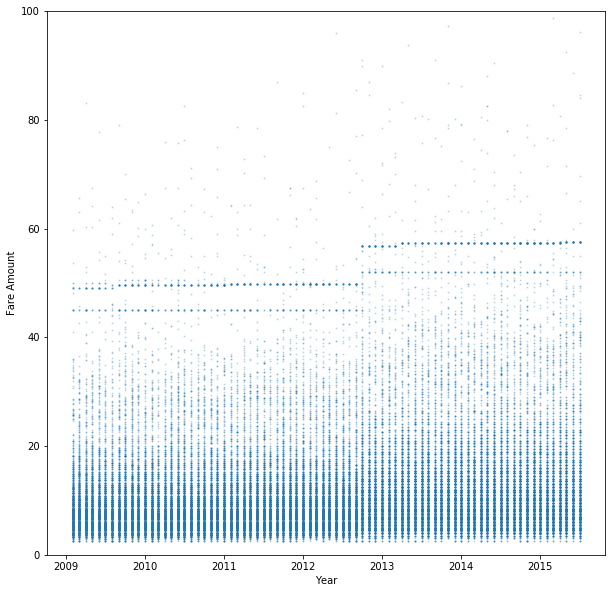

In [12]:
fig, plots = plt.pyplot.subplots(1,1,figsize=(10,10))
plots.scatter(df_train['pickup_datetime'].dt.year+df_train['pickup_datetime'].dt.month/12,df_train['fare_amount'],alpha=0.2, s=1)
plots.set_ylabel('Fare Amount')
plots.set_xlabel('Year')
plots.set_ylim([0, 100])

* *Relationship between ride direction  and fare amount*

Another interesting I found out is that the relationship between direction of rides (in terms of angles) and the fare amount. The code below implements a function for calculating the angles. Following is a plot of the direction against fare amount. We see that there are many rides running at about 55 and -55 degrees. My guess is this is the main street direction of Manhattan, and therefore the road is usually much longer, hence the higher taxi fare. We can use this clue to predict the fare price. Furthermore, rides on these directions (~55 and -55 degrees) have the most correct distance computation because they just go straight. This added information might help the model learn better.

(-180, 180)

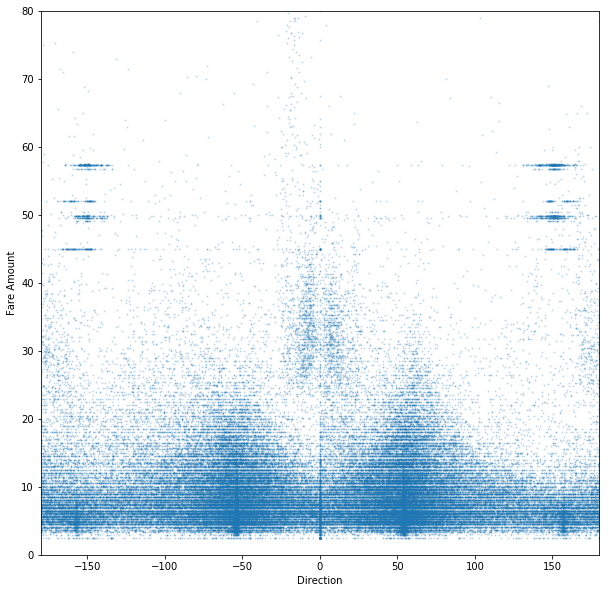

In [13]:
def angle_calculation(pickup_lon, pickup_lan, dropoff_lon, dropoff_lan):
    lon_difference = dropoff_lon - pickup_lon
    lan_difference = dropoff_lan - pickup_lan
    length = np.sqrt(np.power(lon_difference,2) + np.power(lan_difference,2) )    
    cos = lon_difference/length    
    cos[cos>1] = 1
    cos[cos<(-1)] = -1   
    angle = np.arccos(cos) + (-1)*np.pi*(lan_difference < 0)
    angle[np.isnan(angle)] = 0
    angle = angle/np.pi*180    
    return angle
df_train['direction'] = angle_calculation(df_train['pickup_longitude'],df_train['pickup_latitude'],df_train['dropoff_longitude'],df_train['dropoff_latitude'])

fig, plots = plt.pyplot.subplots(1,1,figsize=(10,10))
plots.scatter(df_train['direction'],df_train['fare_amount'],alpha=0.2, s = 1)
plots.set_xlabel('Direction')
plots.set_ylabel('Fare Amount')
plots.set_ylim([0,80])
plots.set_xlim([-180,180])


**Question 6:**

According to our observations in quesiton 4, we find there are ralationships between the year, time of day the ride occurs, the direction and the fare. Therefore, we will include them into the selected features set. Other features we will use are "distance", and "number of passengers".  The "distance" feature seems obvious enough to be included in the features set. For the "number of passengers" feature, although we have not seen an obvious relationship with the fare amount now. However, it might be a latent relationship (maybe through some transformations). Therefore, we will still include it in the feature set.

In conclusion, the set of features we will use for model is:     *[year, time of day, distance, number of passengers, direction]*

We also conduct one more step of processing the features that is normalization in order to have all the features have mean of 0, and standard deviation of 1. This way, we balance the features so that one of them will not overwhelm others.  

The piece of code below extracts selected features along with labels (fare amount), and then split the data into training and validation dataset.

*Caveat: *Here, when building model, we will omit from the training set rides that come from\to JFK, since these rides have a fixed fare amount that likely does not obey the linear model. Actually they can harm the linear model. Therefore, we omit these point when training. 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
df_train['time_of_day'] = df_train['pickup_datetime'].dt.hour
df_train['year'] = df_train['pickup_datetime'].dt.year
df_train['distance'] = surface_distance(df_train['pickup_latitude'],df_train['pickup_longitude'],df_train['dropoff_latitude'],df_train['dropoff_longitude'])
df_train['direction'] = angle_calculation(df_train['pickup_longitude'],df_train['pickup_latitude'],df_train['dropoff_longitude'],df_train['dropoff_latitude'])
JFK_BB = [-73.82,-73.75,40.60,40.67]
def from_or_to_JFK(JFK_BB,df):
    return ((JFK_BB[0]<df['pickup_longitude']) & (df['pickup_longitude']<JFK_BB[1]) & (JFK_BB[2]<df['pickup_latitude']) & (df['pickup_latitude']<JFK_BB[3])) | ((JFK_BB[0]<df['dropoff_longitude']) & (df['dropoff_longitude']<JFK_BB[1]) & (JFK_BB[2]<df['dropoff_latitude']) & (df['dropoff_latitude']<JFK_BB[3]))
df_train = df_train[from_or_to_JFK(JFK_BB,df_train)==False] 
features_selected = ['year','time_of_day','distance', 'passenger_count', 'direction']
X = df_train[features_selected]
X = X*1.0
Y = df_train['fare_amount']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = preprocessing.StandardScaler().fit(X_val)
X_val = scaler.transform(X_val)

We then build a simple linear regression model based on our training data, using the scikit-learn library.

In [17]:
# Building model:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)
model.coef_

# Validating:
def rmse(y1, y2):
    return np.sqrt(np.power((y1 - y2),2).mean())
Y_predicted = model.predict(X_val)
Loss_val = rmse(Y_val,Y_predicted)
Loss_val

4.298651402468729

After tranining, we used the model to give predictions on the testing data, and then uploaded it to Kaggle. The result was not really bad but not good enough also. 

The coefficients are [ 0.85819541,  0.08385848,  6.25397507,  0.04045618, -0.11855698]

According to the features, we find that the "distance" feature is the most important features, which is quite obvious.

**Question 8:**

Now we will have some improvements on the baseline model. The two main suggestions are:
1. We will treat the rides from/to JFK airport seperately, because them seem not following the rules, comparing to other rides. Indeed, they usually have a "fixed" range of price. Therefore, for these rides from/to JFK, we will assign directly the price to be mean([57.33, 49.80, 45.00, 49.57, 52.00 ]). The values of the vector are chosen because they have the highest frequencies among all the rides relating to JFK (more then 2-3 times higher) than other fare.

In general, we will split the testing set into two subsets: rides from\to JFK and rides are not. For the rides from/to JFK, the prediction is given as description above. For rides not from/to JFK, we will use the trained linear model to predict the fare. The final result will be the combination of all the instances.




In [19]:
##### Final model & Submission
# Final model treat points from/to JFK seperately with others
# Preprocessing
df_test['time_of_day'] = df_test['pickup_datetime'].dt.hour
df_test['year'] = df_test['pickup_datetime'].dt.year
df_test['distance'] = surface_distance(df_test['pickup_latitude'],df_test['pickup_longitude'],df_test['dropoff_latitude'],df_test['dropoff_longitude'])
df_test['direction'] = angle_calculation(df_test['pickup_longitude'],df_test['pickup_latitude'],df_test['dropoff_longitude'],df_test['dropoff_latitude'])

# Dividing
X_JFK = df_test[from_or_to_JFK(JFK_BB,df_test)]
X_not_JFK = df_test[from_or_to_JFK(JFK_BB,df_test) == False]
# Predicting X_JFK
Y_JFK = np.mean([57.33, 49.80, 45.00, 49.57, 52.00 ]) + np.zeros([X_JFK.shape[0],1])

# Predicting X_not_JFK    
X_test = X_not_JFK[features_selected]
scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)
X_test = X_test*1.0
Y_not_JFK = model.predict(X_test)

# Combining result
Y_test_predicted = np.zeros([df_test.shape[0],1])
Y_test_predicted[X_JFK.index] = Y_JFK
Y_test_predicted[X_not_JFK.index] = Y_not_JFK.reshape([Y_not_JFK.shape[0],1])
Y_test_predicted


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


array([[10.59629223],
       [10.5349001 ],
       [ 5.45700768],
       ...,
       [50.74      ],
       [22.02427572],
       [ 8.26229971]])

2. We will try implementing a simple Neural Network model. I know it seems to be overcomplicating it, but I just want to play around with Tensorflow and stuff. Caveat: The code of the Neural Network model will be posted here, but maybe not runable because many adjustments needed  in the code. The full code is provided in the submiting files. Also, for the neural network, we also try to learn more samples, that is 2 million rides.

In [ ]:
#import tensorflow as tf
#
#def neural_net_model(X_data,input_dim):
#    W_1 = tf.Variable(tf.random_normal([input_dim,10],),name = 'W_1')
#    b_1 = tf.Variable(tf.random_normal([10]), name = 'b_1')
#    layer_1 = tf.add(tf.matmul(X_data,W_1), b_1)
#    layer_1 = tf.nn.relu(layer_1)
#
#    # layer 1 multiplying and adding bias then activation function
#
#    W_2 = tf.Variable(tf.random_normal([10,10]),name = 'W_2')
#    b_2 = tf.Variable(tf.random_normal([10]),name = 'b_2')
#    layer_2 = tf.add(tf.matmul(layer_1,W_2), b_2)
##    output = layer_2
#    layer_2 = tf.nn.relu(layer_2)
#
#    # layer 2 multiplying and adding bias then activation function
#
#    W_O = tf.Variable(tf.random_uniform([10,1]),name = 'W_O')
#    b_O = tf.Variable(tf.random_uniform([1]),name = 'b_O')
#    output = tf.add(tf.matmul(layer_2,W_O), b_O)
#
#    # O/p layer multiplying and adding bias then activation function
#
#    # notice output layer has one node only since performing #regression
#
#    return output
#
#"""
#neural_net_model is function applying 2 hidden layer feed forward neural net.
#
#Weights and biases are abberviated as W_1,W_2 and b_1, b_2 
#These are variables with will be updated during training.
#
#"""
#
#xs = tf.placeholder(tf.float32, [None, 4])
#ys = tf.placeholder(tf.float32, [None, 1])
#
#output = neural_net_model(xs,4)
#
#cost = tf.reduce_mean(tf.square(output-ys))
#
## our mean squared error cost function
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.00005).minimize(cost)
#
##initialize the variable
#init_op = tf.initialize_all_variables()
#
## Gradinent Descent optimiztion just discussed above for updating weights and biases
#
#c_t = []
#c_val = []
#saver = tf.train.Saver()
#with tf.Session() as sess:
#
#    # Initiate session and initialize all vaiables
#    sess.run(init_op)
#    for i in range(1000):
##        for j in 200:
##            batch_size = 50
##            rand = random(1-X_train.shape[0],batch_size)
##            sess.run([cost,optimizer],feed_dict=    {xs:X_train[rand,:].reshape(-1,4), ys:Y_train.values[rand].reshape(-1,1)})
#        
#        for j in range(X_train.shape[0]):
#            sess.run([cost,optimizer],feed_dict=    {xs:X_train[j,:].reshape(1,4), ys:Y_train.values[j].reshape(1,1)})
#            # Run cost and train with each sample
#
#        c_t.append(sess.run(cost, feed_dict={xs:X_train.reshape(-1,4),ys:Y_train.values.reshape(-1,1)}))
#        c_val.append(sess.run(cost, feed_dict={xs:X_val.reshape(-1,4),ys:Y_val.values.reshape(-1,1)}))
#        print('Epoch ',i,': Cost Train:',np.sqrt(c_t[i]), ' / Cost Val:',np.sqrt(c_val[i]))
#    
#        # Save model
#        if (i%5==0):
#            saver.save(sess, path + "\Models\Model_"+ str(i) + ".ckpt")

**Question 9:**

The code below create the csv file in order to be submitted to Kaggle.


In [20]:

# Submission
df_test['prediction'] = Y_test_predicted
submission = pd.DataFrame(
        {'key': df_test.key, 'fare_amount': df_test.prediction},
    columns = ['key', 'fare_amount'])
submission.to_csv('Homework2.csv', index = False)

For the Linear Regression network, the result was not so good. However, using the Neural Network model, the accuracies increase drastically. 

My rank so far is: ~600

My score is: 3.71810

The result is not so high right now, but I am working on it, tuning the parameters, creating and selecting new features to have a better model.

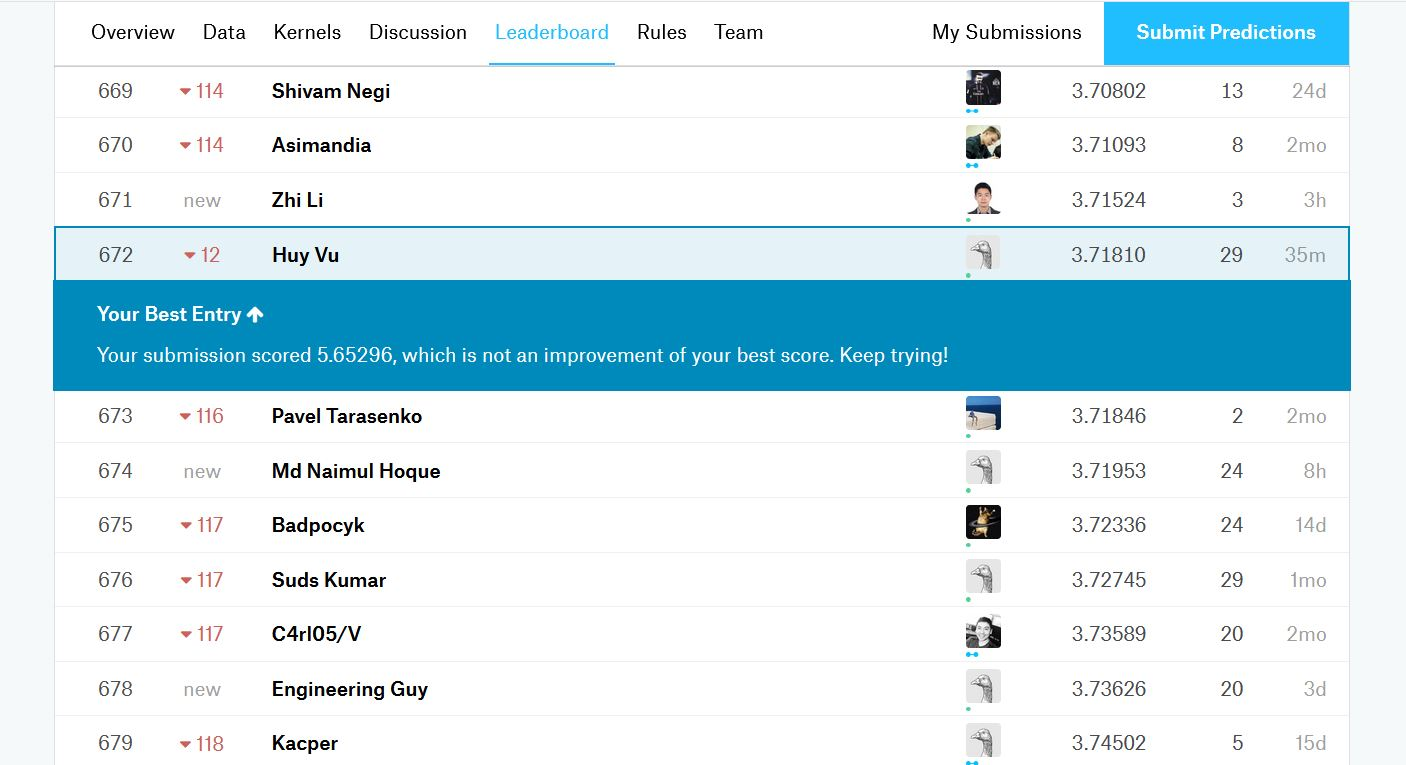